<a href="https://colab.research.google.com/github/lys678/AIFFEL_ONLINE_QUEST04/blob/master/exploration/EX02/news_summarize_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트: 뉴스기사 요약해보기

In [ ]:
# 주요 라이브러리 버전을 확인
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


## Step 1. 데이터 수집하기

### 데이터 다운로드

In [ ]:
import urllib.request
import pandas as pd
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
# 데이터 샘플확인
data.sample(10)

,headlines,text
92069,Abuses by ex-world no.1 leaves British tennis ...,Britain's women's singles number one tennis pl...
2618,"Cabinet approves 3 new AIIMS at Gujarat, Jammu...",The Cabinet on Thursday approved the establish...
44569,Trump imposes tariff on steel and aluminium im...,US President Donald Trump on Thursday signed a...
51111,Chinese man who hid gold worth Ã¢ÂÂ¹52L in je...,Customs officials at the Delhi airport have ar...
85982,Twinkle shares picture with mother Dimple on h...,Novelist Twinkle Khanna took to Instagram to s...
7852,Spinners take all 40 wickets for team in 2-Tes...,Spinners picked up all the 40 wickets for Bang...
82995,"Patna Police officers play games, browse net d...",Two Patna Police officers were caught playing ...
39570,Calls with Trump are like sausages: French Pre...,Comparing his calls with US President Donald T...
2892,Possibility that Vinta accused Alok of rape fo...,A Mumbai sessions court has said actor Alok Na...
63862,Maha's growth slow because of bureaucratsÃ¢ÂÂ...,Ahead of completing three years as Maharashtra...


In [ ]:
# 데이터 개수 확인
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


## Step 2. 데이터 전처리하기 (추상적 요약)

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [ ]:
# 데이터의 중복 샘플 유무를 확인
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [ ]:
# headlines, text 열의 중복 샘플 제거
data.drop_duplicates(subset = ['headlines'], inplace=True)
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


headlines와 text열에서 모두 중복을 제거한 결과 98262개의 샘플만 남았습니다.

In [ ]:
# 데이터프레임에 Null 값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


null 값은 없는 것으로 확인

### 텍스트 정규화와 불용어 제거

In [ ]:
# NLTK 패키지에서 불용어 사전을 다운로드하고, 데이터 전처리를 위한 나머지 패키지 불러오기
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
# 불용어 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
# 전체 headlines 데이터에 대한 전처리
clean_headlines = []

for index, row in data.iterrows():
    clean_headlines.append(preprocess_sentence(row['headlines']))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [ ]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for index, row in data.iterrows():
    clean_text.append(preprocess_sentence(row['text']))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [ ]:
# 보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장
# 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [ ]:
# .isnull().sum()을 사용해서 Null 값이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [ ]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


### 샘플의 최대 길이 정하기

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.136787364393153
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326


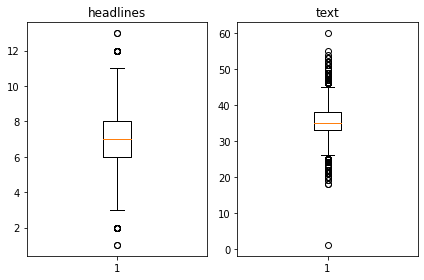

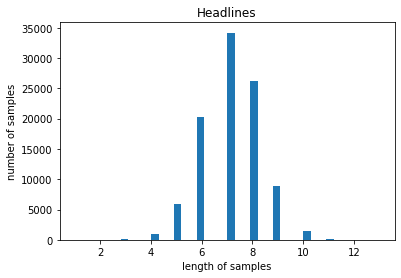

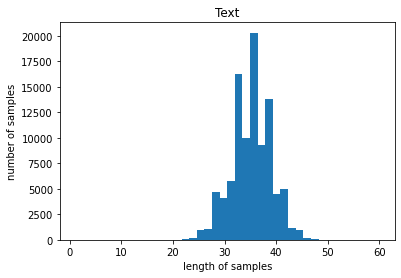

In [ ]:
# headlines와 text의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# headlines의 최대 길이와 text의 적절한 최대 길이를 임의로 지정
headlines_max_len = 12
text_max_len = 50

In [ ]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
# 이렇게 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 확인
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9999796462518573
전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.999857523763001


모두 99.9%이상의 비율을 가지는 것을 보아 샘플의 길이를 조정하는 것이 데이터에 큰 영향을 주지 않을 것을 알 수 있다.

In [ ]:
# headlines와 text를 담고 있는 data 데이터프레임을 위에서 임의로 정의한 headlines_max_len과 text_max_len의 길이보다 큰 샘플을 제외
# apply 함수와 람다식을 사용하여 길이가 지정한 값보다 큰 "headlines" 샘플 제외
data = data[data.apply(lambda x: len(x['headlines'].split()) <= headlines_max_len, axis=1)]

# apply 함수와 람다식을 사용하여 길이가 지정한 값보다 큰 "text" 샘플 제외
data = data[data.apply(lambda x: len(x['text'].split()) <= text_max_len, axis=1)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98246


### 시작 토큰과 종료 토큰 추가하기

In [ ]:
# text 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [ ]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [ ]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[59741 37286 25775 ... 92432 25583 64331]


In [ ]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19649


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78597
훈련 레이블의 개수 : 78597
테스트 데이터의 개수 : 19649
테스트 레이블의 개수 : 19649


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [ ]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69431
등장 빈도가 6번 이하인 희귀 단어의 수: 47307
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22124
단어 집합에서 희귀 단어의 비율: 68.13527098846338
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4765342096620904


In [ ]:
src_vocab = 20000  # 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기가 22124이므로 이와 비슷한 20000으로 지정
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[276, 225, 157, 1112, 124, 4842, 6401, 7865, 1976, 418, 118, 427, 1732, 799, 2839, 7865, 2364, 2839, 32, 431, 386, 153, 7865, 2364, 800, 1732, 6401, 60, 1976, 837, 2483, 13328, 153, 11572], [37, 215, 2583, 89, 59, 988, 181, 3, 13, 3312, 6, 342, 1145, 7, 2546, 615, 894, 3312, 436, 463, 57, 3600], [10, 301, 57, 1582, 10258, 18377, 48, 108, 42, 1007, 430, 672, 14752, 2012, 48, 42, 158, 597, 301, 2711, 172, 6, 2397, 10, 1516, 788, 146, 496, 1233, 2719]]


In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29903
등장 빈도가 5번 이하인 희귀 단어의 수: 19668
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10235
단어 집합에서 희귀 단어의 비율: 65.77266495000501
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.896234529480391


In [ ]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 91, 133, 168, 623, 42, 5549, 375], [1, 5, 48, 5302, 3079, 59], [1, 222, 9375, 1273, 6, 15, 815, 851], [1, 776, 1550, 2410, 4720, 1155, 49], [1, 8, 5, 2158, 4721, 23, 73]]
target
decoder  [[91, 133, 168, 623, 42, 5549, 375, 2], [5, 48, 5302, 3079, 59, 2], [222, 9375, 1273, 6, 15, 815, 851, 2], [776, 1550, 2410, 4720, 1155, 49, 2], [8, 5, 2158, 4721, 23, 73, 2]]


In [ ]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장
# 이 샘플들은 모두 삭제함
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78596
훈련 레이블의 개수 : 78596
테스트 데이터의 개수 : 19648
테스트 레이블의 개수 : 19648


### 패딩하기

In [ ]:
# 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춤
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('전처리 종료')

전처리 종료


### 모델 설계하기

In [ ]:
# API를 이용해서 인코더를 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=False, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output2)

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 66s 104ms/step - loss: 4.7123 - val_loss: 4.3654
Epoch 2/50
308/308 [==============================] - 31s 102ms/step - loss: 4.2089 - val_loss: 4.0616
Epoch 3/50
308/308 [==============================] - 32s 104ms/step - loss: 3.9412 - val_loss: 3.9034
Epoch 4/50
308/308 [==============================] - 33s 106ms/step - loss: 3.7377 - val_loss: 3.7674
Epoch 5/50
308/308 [==============================] - 33s 108ms/step - loss: 3.5733 - val_loss: 3.5946
Epoch 6/50
308/308 [==============================] - 33s 107ms/step - loss: 3.4329 - val_loss: 3.5435
Epoch 7/50
308/308 [==============================] - 33s 107ms/step - loss: 3.3126 - val_loss: 3.5083
Epoch 8/50
308/308 [==============================] - 33s 108ms/step - loss: 3.2093 - val_loss: 3.4220
Epoch 9/50
308/308 [==============================] - 33s 107ms/step - loss: 3.1144 - val_loss: 3.3634
Epoch 10/50
308/308 [==============================] - 33s 107ms/step - l

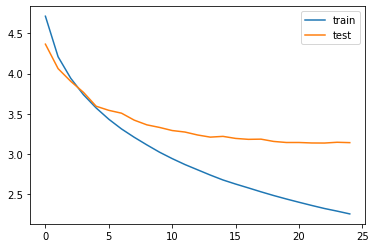

In [ ]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [ ]:
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로,
# 필요한 3개의 사전을 아래와 같이 미리 준비해 둠.
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교합니다.

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("추상 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : us president donald trump youngest son barron trump seen practising football skills white house wearing full arsenal kit year old pictured lawn monday easter egg roll white house several members us professional soccer league major league soccer present lawn party 
실제 요약 : trump son plays football white house arsenal kit 
추상 요약 :  trump son obama meet us open


원문 : growing trees reduce atmospheric carbon dioxide cannot replace cutting emissions fossil fuel burning study warned plants suck co atmosphere build woody roots leaves low tech carbon dioxide removal could combined high tech underground carbon storage mechanisms meet paris climate agreement goals researchers said 
실제 요약 : planting trees substitute cutting co emissions study 
추상 요약 :  use use use water fuel prices


원문 : low cost airline ryanair ceo michael made million last fiscal claimed seriously added shareholders opposed bumper pay packet adding feels appreciated also slammed government proposals would force firms publ

## Step 5. Summa을 이용해서 추출적 요약해보기

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_summa = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
# 추상적 요약을 하는 함수
def textSummary(text) :
    text_preprocess = preprocess_sentence(text)
    text_preprocess = src_tokenizer.texts_to_sequences([text])
    text_preprocess = pad_sequences(text_preprocess, maxlen=text_max_len, padding='post')
    summa = decode_sequence(text_preprocess)
    return summa

In [ ]:
for i in range(50, 100):
    print("원문 :", data_summa['text'][i])
    print("실제 요약 :", data_summa['headlines'][i])
    print("추상 요약 :", textSummary(data_summa['text'][i]))
    print("추출 요약 :", summarize(data_summa['text'][i], ratio=0.3))
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
추상 요약 :  ex rbi deputy deputy governor booked rafale scam
추출 요약 : 


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight year, delivering 806 aircraft in 2018. 
실제 요약 : Boeing sales cross $100bn for 1st time in its 102-yr 

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("추상 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출 요약 :", summarize(data_summa['text'][i], ratio=0.7))  # ratio값을 0.7로 조정
    print("\n")

원문 : us president donald trump youngest son barron trump seen practising football skills white house wearing full arsenal kit year old pictured lawn monday easter egg roll white house several members us professional soccer league major league soccer present lawn party 
실제 요약 : trump son plays football white house arsenal kit 
추상 요약 :  trump son obama meet us open
추출 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.


원문 : growing trees reduce atmospheric carbon dioxide cannot replace cutting emissions fossil fuel burning study warned plants suck co atmosphere build woody roots leaves low tech carbon dioxide removal could combined high tech underground carbon storage mechanisms meet paris climate agreement goals researchers said 
실제 요약 : p

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("추상 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출 요약 :", summarize(data_summa['text'][i], ratio=0.5))  # ratio값을 0.5로 조정
    print("\n")

원문 : us president donald trump youngest son barron trump seen practising football skills white house wearing full arsenal kit year old pictured lawn monday easter egg roll white house several members us professional soccer league major league soccer present lawn party 
실제 요약 : trump son plays football white house arsenal kit 
추상 요약 :  trump son obama meet us open
추출 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : growing trees reduce atmospheric carbon dioxide cannot replace cutting emissions fossil fuel burning study warned plants suck co atmosphere build woody roots leaves low tech carbon dioxide removal could combined high tech underground carbon storage mechanisms meet paris climate agreement goals researchers said 
실제 요약 : planting trees substitute cutting co emissions study 
추상 요약 :  use use use water fuel prices
추출 요약 : Boeing retained its position as the 

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("추상 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출 요약 :", summarize(data_summa['text'][i], ratio=0.4))  # ratio값을 0.4로 조정
    print("\n")

원문 : us president donald trump youngest son barron trump seen practising football skills white house wearing full arsenal kit year old pictured lawn monday easter egg roll white house several members us professional soccer league major league soccer present lawn party 
실제 요약 : trump son plays football white house arsenal kit 
추상 요약 :  trump son obama meet us open
추출 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : growing trees reduce atmospheric carbon dioxide cannot replace cutting emissions fossil fuel burning study warned plants suck co atmosphere build woody roots leaves low tech carbon dioxide removal could combined high tech underground carbon storage mechanisms meet paris climate agreement goals researchers said 
실제 요약 : planting trees substitute cutting co emissions study 
추상 요약 :  use use use water fuel prices
추출 요약 : Boeing retained its position as the 

### 결과를 비교하는 데이터프레임 만들기

In [ ]:
results = []

for i in range(50, 100):
    original_text = seq2text(encoder_input_test[i])
    actual_summary = seq2headlines(decoder_input_test[i])
    abstract_summary = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    extractive_summary = summarize(data_summa['text'][i], ratio=0.5)

    results.append({
        original_text,
        actual_summary,
        abstract_summary,
        extractive_summary
    })

df = pd.DataFrame(results)
df.head()

,0,1,2,3
0,Former Finance Minister Yashwant Sinha on Tues...,trump son obama meet us open,us president donald trump youngest son barron ...,trump son plays football white house arsenal kit
1,growing trees reduce atmospheric carbon dioxid...,use use use water fuel prices,Boeing retained its position as the world's la...,planting trees substitute cutting co emissions...
2,ceo loses billion tax ceo,,seriously underpaid says ryanair ceo,low cost airline ryanair ceo michael made mill...
3,singapore demands lakh indians,boeing airbus group supplier fined investigati...,"Further, its OnePlus 6 emerged as the highest ...",boeing supplier fined cr discrimination muslims
4,"Filmmaker Pooja Bhatt, while talking about the...",tamil nadu health department wednesday launche...,tamil nadu hospital doctors remove nipah virus,tamil nadu starts free breast implants poor


## 회고

NLP를 다루면서 RNN모델에 관한 이해를 더 깊게 해 볼 수 있는 시간이었다.
직접 코딩해보니 평소에 알고 있다고 생각했던 개념들을 정확히 알지는 못하고 있었다고 확인하는 계기가 되었다.

기계는 같은 의미라고 생각하지만, 인간이 보기에 같은 의미라고 볼 수 없는 요약들이 다수 존재했다.
NLP 작업을 통한 요약은 최종적인 loss 값이 낮게 나오더라도 인간이 이해하지 못하거나 잘못된 내용을 전달할 수도 있겠다는 생각이 들었다.
마지막에 summa를 이용하는 과정에서 ratio 값에 따라 추출 요약이 나오거나 나오지 않는 경우가 있었다.
이는 요약을 하는 과정에서 ratio의 값이 너무 낮으면 문법적으로 올바른 내용을 만들기도 어렵고 내용상으로도 요약이라기보다는 키워드 몇 개를 추출하는 형태로 코드가 실행되어 요약이라고 할 수 없는 경우가 발생하게 된다.
따라서 ratio 값을 적절히 조절하여 사용자가 읽기 편하면서 추출 요약이 실행되는 최적의 ratio 값을 찾아서 대입해야 한다.

생각보다 val_loss의 값이 크게 변화하는 일은 없었다.
이는 NLP의 특성상 많은 언어를 다루며 학습하기 때문에 어떤 문장이 쓰이더라도 개발자가 이에 대한 가중치 등의 변화를 주지 않는 한 val_loss 값에 큰 변화를 주지는 못한다는 생각이 들었다.

모델을 만들면서 원문과 무관한 내용이 많이 등장하였다. 또한 추상적 요약에서는 원문과 무관한 내용이 많았고, 추출적요약에서는 사람이 읽을 수 없는 이상한 문자들이 포함되는 경우가 많았다. 이는 조금 더 좋은 모델이 개발되거나 다른 요약작업을 시도해야 할 것으로 생각된다.